# PAYROLL CLASSIFIER PROBLEM

**GOAL:**

**The goal of this problem is to build a classifier that has the ability to classify the payroll from the transaction records of all the users at Earnin.**






**RECORDS/DATA:**

**The transaction records contains UserId, TransactionId, Amount of each transaction, Description of each transaction, Date of each transcation, Pending status, and Categories**
**The result is if a transaction is truely a payroll or not.**

**We load the libraries.**


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

# DATA PREPARATION AND FEATURE SELECTION
**The UserId is named as id/userid, the TransactionId is named as transid/payid, the description of each transaction is named as desc.**  

In [2]:
Location=r'C:\Users\wang\Desktop\Assignment\BankTransactions_credit.csv'
df_trans = pd.read_csv(Location,header=None,low_memory=False,skiprows=1,usecols=[0,1,2,3,4],names=['id','transid','amount','desc','date'])
df_trans.head()

,id,transid,amount,desc,date
0,458919,keNBRdadnXHk11E8R347H411rvXpOgCp5NQe0,3.33,TRANSFER #913536 FROM CHECKING XXX-XXX-2820,2016-12-19T00:00:00-05:00
1,458919,YV6B45w5RQc9778D4aOyfr77zaxd6VFnvoyX8,50.68,TRANSFER #869194 FROM CHECKING XXX-XXX-2820,2016-12-15T00:00:00-05:00
2,458919,EgkZXDPDaoSA55y4oM6pfXrBQ9p4PMUEEjNnX,35.00,TRANSFER #393115 FROM CHECKING XXX-XXX-2561,2016-11-23T00:00:00-05:00
3,458919,KXxEMykyaoTv77J3ZVpXiAKJeo4OL1tNNMzBp,10.00,TRANSFER #761283 FROM CHECKING XXX-XXX-2820,2016-10-24T00:00:00-04:00
4,458919,AZJ7nd6dEVip55bDZVx0SqaE1V9w6oijjROEV,36.00,TRANSFER #723271 FROM CHECKING XXX-XXX-2820,2016-10-24T00:00:00-04:00


In [3]:
Location1=r'C:\Users\wang\Desktop\Assignment\UserPayrollTracking.csv'
df_pay = pd.read_csv(Location1,header=None,low_memory=False,skiprows=1,usecols=[0,4],names=['userid','payid'])
df_pay.head()

,userid,payid
0,458919,NaN
1,458919,NaN
2,458919,OVPaZvjvmocnooeD83jEh6aengV1V8UeQMXZB
3,458919,NaN
4,458919,NaN


**In order to conduct the correct join of two tables, we need to clean the data. **

**We remove the duplicated rows with the same transid.**

**Then, we join the two tables to form a concrete table.**

In [4]:
df_trans=df_trans.drop_duplicates(['transid'])
df_pay=df_pay.drop_duplicates(['payid'])


In [5]:
df=pd.merge(df_trans, df_pay, how='left', left_on=['transid'], right_on=['payid'])
len(df)

1192377

In [6]:
df.head()

,id,transid,amount,desc,date,userid,payid
0,458919,keNBRdadnXHk11E8R347H411rvXpOgCp5NQe0,3.33,TRANSFER #913536 FROM CHECKING XXX-XXX-2820,2016-12-19T00:00:00-05:00,NaN,NaN
1,458919,YV6B45w5RQc9778D4aOyfr77zaxd6VFnvoyX8,50.68,TRANSFER #869194 FROM CHECKING XXX-XXX-2820,2016-12-15T00:00:00-05:00,NaN,NaN
2,458919,EgkZXDPDaoSA55y4oM6pfXrBQ9p4PMUEEjNnX,35.00,TRANSFER #393115 FROM CHECKING XXX-XXX-2561,2016-11-23T00:00:00-05:00,NaN,NaN
3,458919,KXxEMykyaoTv77J3ZVpXiAKJeo4OL1tNNMzBp,10.00,TRANSFER #761283 FROM CHECKING XXX-XXX-2820,2016-10-24T00:00:00-04:00,NaN,NaN
4,458919,AZJ7nd6dEVip55bDZVx0SqaE1V9w6oijjROEV,36.00,TRANSFER #723271 FROM CHECKING XXX-XXX-2820,2016-10-24T00:00:00-04:00,NaN,NaN


** We remove the rows where the description portions are blank** 

In [7]:
df['payid'][pd.isnull(df['payid'])]=0
df['payid'][df['payid']!=0]=1
del df['transid']
del df['userid']

In [8]:
df=df[pd.isnull(df['desc'])==0]

In [9]:
df.head()


,id,amount,desc,date,payid
0,458919,3.33,TRANSFER #913536 FROM CHECKING XXX-XXX-2820,2016-12-19T00:00:00-05:00,0
1,458919,50.68,TRANSFER #869194 FROM CHECKING XXX-XXX-2820,2016-12-15T00:00:00-05:00,0
2,458919,35.00,TRANSFER #393115 FROM CHECKING XXX-XXX-2561,2016-11-23T00:00:00-05:00,0
3,458919,10.00,TRANSFER #761283 FROM CHECKING XXX-XXX-2820,2016-10-24T00:00:00-04:00,0
4,458919,36.00,TRANSFER #723271 FROM CHECKING XXX-XXX-2820,2016-10-24T00:00:00-04:00,0


** We separate the whole table into two tables according to whether the transaction is a payroll or not.**

In [10]:
df_1=df[df['payid']==1]
df_0=df[df['payid']==0]

**In order to build an accurate classifier, it is pivotal to select the usefull features based on the cleaned data. **

**We want to know the characteristics of the potential features based on data visualization.**

**We first want to know what the proportion is for a true payroll within all the bank transactions.**

**We find the actual number of payroll is around 36000 out of 1200000 transactions.**

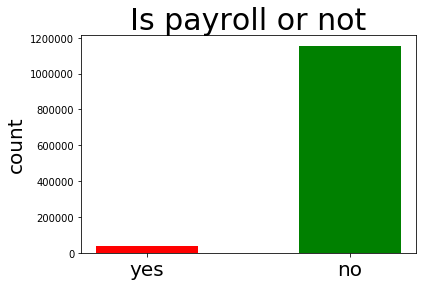

In [11]:
plt.bar([1,2], [len(df_1),len(df_0)],width=0.5,color=['r','g'])
plt.xticks([1,2],['yes','no'],fontsize=20)
plt.yticks(fontsize=10)
plt.ylabel('count',fontsize=20)
plt.title('Is payroll or not',fontsize=30,color='k')
plt.show()

**Intuitively, the classifier should be heavily based on the description of each transaction. The descriptions for true payrolls should have common characteristics among all the transactions, such as "direct deposit", "ACH", and so on.**

**We thus count the frequency of each key word appearred in each payroll and sort them by frequency.**

In [12]:

dic={}
for i in range(len(df_1)):
    for j in df_1.iloc[i]['desc'].lower().split():
        if j not in dic:
            dic[j]=1
        else:
            dic[j]+=1
            

**We are not surprised to find that the most frequent key words are "dep", "payroll","ach",deposit","dep",direct","dir",etc.**

In [13]:
sorted(dic.items(),key=lambda x: x[1],reverse=True)[:20]

[('co', 13017),
 ('orig', 11036),
 ('dep', 10329),
 ('payroll', 9574),
 ('direct', 6344),
 ('entry', 5596),
 ('ach', 5391),
 ('sec:ppd', 5047),
 ('deposit', 4960),
 ('credit', 4355),
 ('on', 3187),
 ('ppd', 3025),
 ('id:', 2536),
 ('descr:payroll', 2066),
 ('dir', 1801),
 ('-', 1790),
 ('m', 1716),
 ('descr:direct', 1617),
 ('sears', 1567),
 ('holdings', 1548)]

**Now we have a brief idea about the frequency of the key words within the description of each payroll.**

**We want to know the frequency of those keywords in the non-payroll transactions to get a better idea on whether we should apply those key words as a criteria.**

**We find that the the ratio of "dep" occurred in non-payroll and payroll is 0.2 and 0.42, the difference is not significant;**

**The ratio of "dir" occurred in non-payroll and payroll is 0.31 and 0.13, the difference is also not significant;**

**However, the ratio of "dir" and "dep" both occurred in non-payroll and payroll is 0.3 and 0.05, the difference is significant;**

**The ratio of "payroll" occurred in non-payroll and payroll is 0.34 and 0.05, the difference is significant;**

**The ratio of "ach" occurred in non-payroll and payroll is 0.15 and 0.03, the difference is significant;**

**The ratio of "ppd" occurred in non-payroll and payroll is 0.22 and 0.07, the difference is significant;**

**We can also get a better idea on this by looking at the bar plot.**

In [14]:
c_dep_1=len(df_1[df_1['desc'].str.lower().str.match(r'.*dep.*')==True])/len(df_1)
c_dir_1=len(df_1[df_1['desc'].str.lower().str.match(r'.*dir.*')==True])/len(df_1)
c_dep_dir_1=len(df_1[df_1['desc'].str.lower().str.match(r'(.*dir.*dep.*)|(.*dep.*dir.*)')==True])/len(df_1)
c_payroll_1=len(df_1[df_1['desc'].str.lower().str.match(r'.*payroll.*')==True])/len(df_1)
c_ach_1=len(df_1[df_1['desc'].str.lower().str.match(r'.*ach.*')==True])/len(df_1)
c_ppd_1=len(df_1[df_1['desc'].str.lower().str.match(r'.*ppd.*')==True])/len(df_1)


c_dep_0=len(df_0[df_0['desc'].str.lower().str.match(r'.*dep.*')==True])/len(df_0)
c_dir_0=len(df_0[df_0['desc'].str.lower().str.match(r'.*dir.*')==True])/len(df_0)
c_dep_dir_0=len(df_0[df_0['desc'].str.lower().str.match(r'(.*dir.*dep.*)|(.*dep.*dir.*)')==True])/len(df_0)
c_payroll_0=len(df_0[df_0['desc'].str.lower().str.match(r'.*payroll.*')==True])/len(df_0)
c_ach_0=len(df_0[df_0['desc'].str.lower().str.match(r'.*ach.*')==True])/len(df_0)
c_ppd_0=len(df_0[df_0['desc'].str.lower().str.match(r'.*ppd.*')==True])/len(df_0)

lst=[c_dep_1,c_dir_1,c_dep_dir_1,c_payroll_1,c_ach_1,c_ppd_1,c_dep_0,c_dir_0,c_dep_dir_0,c_payroll_0,c_ach_0,c_ppd_0]
lst

[0.4270713068338006,
 0.309802627961955,
 0.3037275276265875,
 0.338776183407554,
 0.15270218263785804,
 0.2243388861399747,
 0.20462945978964708,
 0.13299249332913413,
 0.05126443623828921,
 0.0596190252056634,
 0.03346248221967654,
 0.07441519607673486]

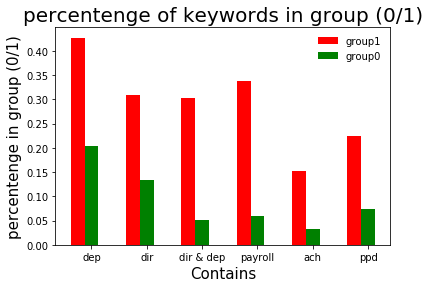

In [15]:
bar_width = 0.5
a=np.array([1,3,5,7,9,11])
b=a+bar_width
plt.bar(a, [lst[0],lst[1],lst[2],lst[3],lst[4],lst[5]],width=0.5,color='r')
plt.bar(b,[lst[6],lst[7],lst[8],lst[9],lst[10],lst[11]] ,width=0.5,color='g')
plt.xticks(b,['dep','dir','dir & dep','payroll','ach','ppd'],fontsize=10)
plt.xlabel('Contains',fontsize=15)
plt.yticks(fontsize=10)
plt.ylabel('percentenge in group (0/1)',fontsize=15)
plt.title('percentenge of keywords in group (0/1)',fontsize=20,color='k')
plt.legend(['group1','group0'],edgecolor='w')
plt.show()

**Therefore, it will be reasonable to treat the keyweods "dir, dep"(both), "payroll","ach",and "ppd" as selected features to help classify the true payroll among all the bank transactions.**

**Next, we take a look at other potential features.**

**We will not select Pending Status and Categories as features as they contain little information and may be incomplete and inaccurate as mentioned.**

**The only two potential features left are :**

**1. amount;**

**2. date.**

**We first look at the amount.**

**There are two ways to treat amount as features:**

**1. Treat "amount" as continuous variable;**

**2. Treat "amount" as categorical variable.**

**We plot the histograms of amount within the true payroll group (group1):**

**It is clear that amount can be assumed as a normal distribution and the average is around 500.The data are not highly skewed, so we do not need to perform transformation (log) on the data.**

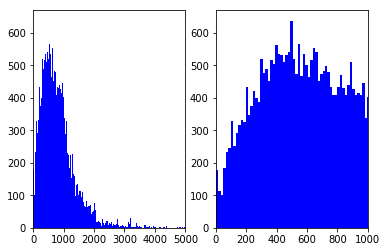

In [248]:
plt.subplot(1,2,1)
plt.hist(list(df_1['amount']), bins=5000,fc='b')
plt.xlim(0,5000)
plt.subplot(1,2,2)
plt.hist(list(df_1['amount']), bins=5000,fc='b')
plt.xlim(0,1000)
plt.show()

**We do not plot the histogram of amount within the non-payroll group (group0) due to the huge data size. Yet we count the frequency of the amount which is less than 150 within both groups.**

**We find that in true payroll group (group1), there are only less than 6% transactions that are below 150;**

**However, in non-payroll group (group0), the ratio is much higher (over 70%).**

**We plot the histograms below. Thus, we can treat amount as a categorical variable and set amount > 150 as 1, and < 150 as 0.**

In [16]:
r0=len(df_0[df_0['amount']<150])/len(df_0)
r1=len(df_1[df_1['amount']<150])/len(df_1)
l=[r0,r1]
l

[0.722877868645373, 0.05434603331683985]

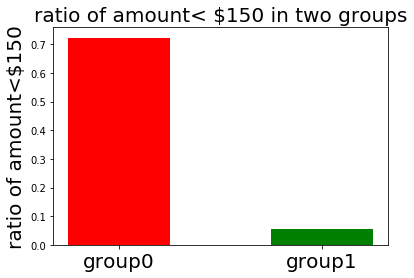

In [17]:
plt.bar([1,2], [r0,r1],width=0.5,color=['r','g'])
plt.xticks([1,2],['group0','group1'],fontsize=20)
plt.yticks(fontsize=10)
plt.ylabel('ratio of amount<$150',fontsize=20)
plt.title('ratio of amount< $150 in two groups',fontsize=20,color='k')
plt.show()

** The last potential feature is date.**

**Intuitively, it might be true that different companies or employers might have their different payroll dates.**

**Here, we are not going to build tons of classifiers based on the individual user or his or her employer.** 

**In other words, because the goal of this study is to build a classifier that can be suitable for a new user. We do not want to build thousands of individual classfiers and use a lookup table to find the exact employer given an employee's name and decide which classifier we should use for that particular company or employer.**  

**Therefore, date variable might contain less information if we were to build a classifier based on all different users. However, it can be still worthy to try and see if there is any different date pattern between true payroll and non-payroll.** 

In [18]:
import datetime

df_1['date'].replace(r'(.*)T.*',r'\1',regex=True,inplace=True)
l1=[]
df_weekday={}
for i in range(len(df_1)):
    s=datetime.datetime.strptime(df_1.iloc[i]['date'], '%Y-%m-%d').strftime('%u')
    if s not in df_weekday:
        df_weekday[s]=1
    else:
        df_weekday[s]+=1
    l1.append(s)
    
    
df_0['date'].replace(r'(.*)T.*',r'\1',regex=True,inplace=True)
l0=[]
df_weekday_0={}
for i in range(len(df_0)):
    s=datetime.datetime.strptime(df_0.iloc[i]['date'], '%Y-%m-%d').strftime('%u')
    if s not in df_weekday_0:
        df_weekday_0[s]=1
    else:
        df_weekday_0[s]+=1
    l0.append(s)
   

**Interestingly, from the plot below, we can find that most payrolls occurred on Friday, despite of different companies or employers.**

**On the contrary, there is no obvious date pattern for non-payroll bank transactions. All the non-payroll transactions are relatively evenly distributed between Monday and Friday.**

**Therefore, we can set date as a categorical variable.**

**Specificly, we set the indicator to 1 when the transaction is made on Thursday or Friday; and we set the indicator to 0 elsewhere.**

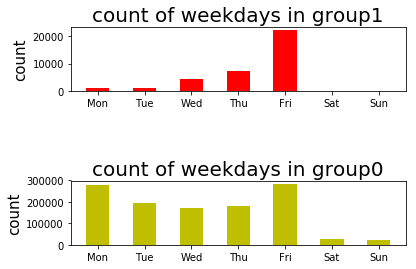

In [19]:
plt.subplot(3,1,1)
bar_width = 0.5
a=np.array([1,2,3,4,5,6,7])
plt.bar(a, [df_weekday['1'],df_weekday['2'],df_weekday['3'],df_weekday['4'],df_weekday['5'],df_weekday['6'],df_weekday['7']],width=0.5,color='r')

plt.xticks(a,['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],fontsize=10)

plt.yticks(fontsize=10)
plt.ylabel('count',fontsize=15)
plt.title('count of weekdays in group1',fontsize=20,color='k')

plt.subplot(3,1,3)
bar_width = 0.5
a=np.array([1,2,3,4,5,6,7])
plt.bar(a, [df_weekday_0['1'],df_weekday_0['2'],df_weekday_0['3'],df_weekday_0['4'],df_weekday_0['5'],df_weekday_0['6'],df_weekday_0['7']],width=0.5,color='y')

plt.xticks(a,['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],fontsize=10)

plt.yticks(fontsize=10)
plt.ylabel('count',fontsize=15)
plt.title('count of weekdays in group0',fontsize=20,color='k')



plt.show()

In [20]:
l1=list(map(int, l1))
l0=list(map(int, l0))
df_1['weekday']=l1
df_0['weekday']=l0

In [21]:
df=pd.concat([df_0,df_1])

# UNBALANCED DATA

**We decide to build two logistic classifiers:**

**1. A logistic classifier with features: (1) keyword including "dir" and "dep" both (or not); (2) keyword including "payroll" (or not); (3) keyword including "ach" (or not); (4) keyword including "ppd" (or not); (5) weekday is Thursday or Friday (or not); (6) amount is greater than 150 (or not).**

**2. A logistic classifier with the same features except treating amount as continuous variable.**

**However, the dataset is highly unbalanced. The classifier based on such data could be treating the true payroll as a random noise and dedicated in predicting the true 0 values instead of true 1 values.**

**The approaches to handling unbalanced data are:**

**1. Random Under-Sampling;**

**2. Random Over-Sampling;**

**3. Synthetic Minority Over-sampling; **

**4. Gradient Tree Boosting ensemble method and boosting based methods.**

**We decide to apply the Random Under-Sampling method:**

** We separate the original data into non-payroll group (group0) and true payroll group (group1).**

** We sample 40000 (comparable to the samples in group1) samples using the sampling without replacement technique from group0.**

**We conbine the sampled group0 with the unchanged group1 and build the classifier.**

**It certainly has pros and cons:**

**Advantages:**

**It can help improve run time and storage problems by reducing the number of training data samples when the training data set is huge.**

**Disadvantages:**

**It can discard potentially useful information which could be important for building rule classifiers.**

**The sample chosen by random under sampling may be a biased sample. And it will not be an accurate representative of the population. Thereby, resulting in inaccurate results with the actual test data set.**

In [22]:

df_2=df.copy()
df_2_na=df.copy()
df_2['word1']=0
df_2['word2']=0
df_2['word3']=0
df_2['word4']=0
df_2['tf']=0

df_2['word1'][df_2['desc'].str.lower().str.match(r'(.*dir.*dep.*)|(.*dep.*dir.*)')==True]=1
df_2['word2'][df_2['desc'].str.lower().str.match(r'.*payroll.*')==True]=1
df_2['word3'][df_2['desc'].str.lower().str.match(r'.*ach.*')==True]=1
df_2['word4'][df_2['desc'].str.lower().str.match(r'.*ppd.*')==True]=1
df_2['tf'][df_2['weekday'] ==4]=1
df_2['tf'][df_2['weekday'] ==5]=1
df_2.head(100)
        
df_2_na['word1']=0
df_2_na['word2']=0
df_2_na['word3']=0
df_2_na['word4']=0
df_2_na['tf']=0
df_2_na['amount150']=0

df_2_na['word1'][df_2_na['desc'].str.lower().str.match(r'(.*dir.*dep.*)|(.*dep.*dir.*)')==True]=1
df_2_na['word2'][df_2_na['desc'].str.lower().str.match(r'.*payroll.*')==True]=1
df_2_na['word3'][df_2_na['desc'].str.lower().str.match(r'.*ach.*')==True]=1
df_2_na['word4'][df_2_na['desc'].str.lower().str.match(r'.*ppd.*')==True]=1
df_2_na['tf'][df_2_na['weekday'] ==4]=1
df_2_na['tf'][df_2_na['weekday'] ==5]=1
df_2_na['amount150'][df_2_na['amount']>=150]=1


In [23]:
################Sampling#############
df_one=df_2[df_2['payid']==1]
df_one_na=df_2_na[df_2_na['payid']==1]
df_zero=df_2[df_2['payid']==0]
df_zero_na=df_2_na[df_2_na['payid']==0]

len(df_zero)


1155772

In [24]:
indexes=np.random.randint(0,len(df_zero_na),40000)
df_zero_na_s=df_zero_na.iloc[indexes]

indexes=np.random.randint(0,len(df_zero),40000)
df_zero_s=df_zero.iloc[indexes]

In [25]:
df_2_s=pd.concat([df_zero_s,df_one])
df_2_na_s=pd.concat([df_zero_na_s,df_one_na])

In [26]:
features=df_2_s[['amount','word1','word2','word3','word4','tf']]
features_na=df_2_na_s[['word1','word2','word3','word4','tf','amount150']]
result=df_2_s['payid']
result_na=df_2_na_s['payid']


In [27]:
result=result.astype('int')

In [28]:
result_na=result_na.astype('int')

# BUILD AND EVALUATE THE CLASSIFIER

** We now have two sets of data. One has amount as categorical variable; One has amount as continuous variable.**

**We now split the data into training (75%) and validating (25%) sets.We will do cross-validation later.**

**We assume the penalty parameter C=10.**

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [30]:
X_train, X_test, y_train, y_test = (
train_test_split(features.as_matrix(),
                result.as_matrix(), test_size=0.25,
                random_state = 1))

In [31]:
X_train_na, X_test_na, y_train_na, y_test_na = (
train_test_split(features_na.as_matrix(),
                result_na.as_matrix(), test_size=0.25,
                random_state = 1))

In [32]:
clf = LogisticRegression(C=10).fit(X_train,y_train)
clf_na = LogisticRegression(C=10)
clf_na.fit(X_train_na,y_train_na)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
train_score = clf.score(X_train, y_train)
train_score_na = clf_na.score(X_train_na, y_train_na)

In [34]:
test_score = clf.score(X_test, y_test)
test_score_na = clf_na.score(X_test_na, y_test_na)

In [35]:
logit_predicted=clf.predict(X_test)
logit_predicted_na=clf_na.predict(X_test_na)

# Confusion Matrix
**The confusion matrices suggest that both classfiers did a great job on the testing data. The classfier that treats amount as categorical variable might be better.** 

**For the classifier that treats amount as continuous variable:** 

**we have 8945+6139 correct predictions and 1159+2852 incorrect predictions.**

In [269]:
confusion = confusion_matrix(y_test,logit_predicted )
confusion

array([[8888, 1216],
       [2852, 6139]], dtype=int64)

**For the classifier that treats amount as categorical variable:** 

**we have 8257+7971 correct predictions and 1847+1020 incorrect predictions.**

In [270]:
confusion_na = confusion_matrix(y_test_na,logit_predicted_na )
confusion_na

array([[8289, 1815],
       [1020, 7971]], dtype=int64)

# Scores

**The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.**

**The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.**

**The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.**

**Because we are interested in classifying the true payrolls as many as possible more than classifying the non-payrolls, we are intersted in Recall more than Accuracy and Precision.** 

**The scores below suggest that the classifier that treats amount as categorical variable is better, although both classifiers did well.**

**For the classifier that treats amount as continuous variable:**

**The Accuracy is: 0.82;**

**The Precision is: 0.82;**

**The Recall is: 0.79;**

**The F1 Score is: 0.80.**

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, logit_predicted)))
print('Precision:',(precision_score(y_test, logit_predicted)))
print('Recall:',(recall_score(y_test, logit_predicted)))
print('F1: ',(f1_score(y_test, logit_predicted)))

Accuracy: 0.82
Precision: 0.827618272696
Recall: 0.791903014125
F1:  0.809366829601


**For the classifier that treats amount as categorical variable:**

**The Accuracy is: 0.85;**

**The Precision is: 0.81;**

**The Recall is: 0.88;**

**The F1 Score is: 0.85.**

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('Accuracy: {:.2f}'.format(accuracy_score(y_test_na, logit_predicted_na)))
print('Precision:',(precision_score(y_test_na, logit_predicted_na)))
print('Recall:',(recall_score(y_test_na, logit_predicted_na)))
print('F1: ',(f1_score(y_test_na, logit_predicted_na)))

Accuracy: 0.85
Precision: 0.818536785861
Recall: 0.885997108219
F1:  0.850932008759


# Precision-Recall Curve and ROC

In [38]:
y_scores_lr = clf.decision_function(X_test)
y_scores_lr
y_scores_lr_na = clf_na.decision_function(X_test_na)
y_scores_lr_na

array([ 0.0960869 ,  2.05825035,  0.68521794, ..., -3.2864945 ,
        2.15771795,  2.15771795])

** The Recall-Precision Curve suggests the trade-off between Recall and Precision. It indicates that in order to achieve a certain Precision, how much Recall do we need to lose.**

**For the classifier that treats amount as continuous variable, the red dot in the plot below is not close to the right top corner.
If the Precision is required to be greater than say, 0.85, the Recall will decrease dramatically and we will lose much Recall.** 

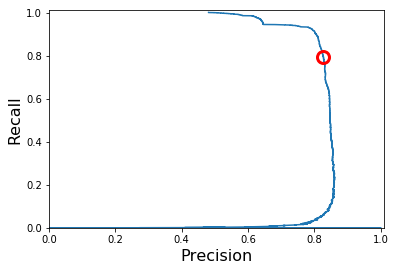

In [39]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)

plt.show()

**For the classifier that treats amount as categorical variable, the red dot in the plot below is much closer to the right top corner. If we want to achieve say, 0.85 Precision,we will not lose much Recall.** 

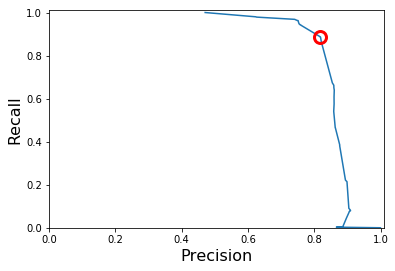

In [40]:
precision, recall, thresholds = precision_recall_curve(y_test_na, y_scores_lr_na)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)

plt.show()

**The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).**

**For the classifier that treats amount as continuous variable, the ROC curver is far away from baseline, suggesting the classifier is robust.**

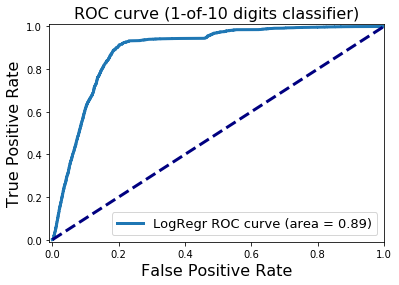

In [41]:
from sklearn.metrics import roc_curve, auc

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_scores_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.show()

**For the classifier that treats amount as categorical variable, the ROC curver is even far away from baseline, suggesting the classifier is more robust.**

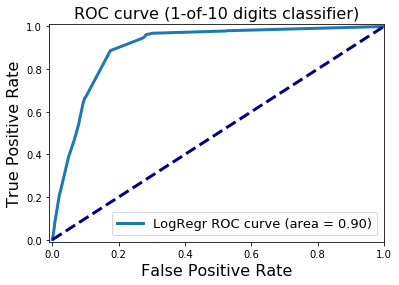

In [42]:
fpr_lr, tpr_lr, _ = roc_curve(y_test_na, y_scores_lr_na)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.show()

# Cross-Validation

**We then conduct 5-fold Cross-Validation for both models.**

**We find that both classifiers have high average scores, the classifier that treats amount as categorical variable is better, especially at achieving higher Recall.**

In [43]:
from sklearn.model_selection import cross_val_score

print('The Classifier that treats amount as continuous variable:')

print('Cross-validation (accuracy)', cross_val_score(clf, features, result, cv=5))

print('Cross-validation (AUC)', cross_val_score(clf, features, result, cv=5, scoring = 'roc_auc'))

print('Cross-validation (recall)', cross_val_score(clf, features, result, cv=5, scoring = 'recall'))

print('')

print('The Classifier that treats amount as categorical variable:')

print('Cross-validation (accuracy)', cross_val_score(clf_na, features_na, result_na, cv=5))

print('Cross-validation (AUC)', cross_val_score(clf_na, features_na, result_na, cv=5, scoring = 'roc_auc'))

print('Cross-validation (recall)', cross_val_score(clf_na, features_na, result_na, cv=5, scoring = 'recall'))

The Classifier that treats amount as continuous variable:
Cross-validation (accuracy) [ 0.85041896  0.83706468  0.81042158  0.79725041  0.83423895]
Cross-validation (AUC) [ 0.91047798  0.90935715  0.87954668  0.86730046  0.89665637]
Cross-validation (recall) [ 0.8411215   0.81830676  0.75219901  0.71862543  0.80549828]

The Classifier that treats amount as categorical variable:
Cross-validation (accuracy) [ 0.87411626  0.87130139  0.83431527  0.82461538  0.85924714]
Cross-validation (AUC) [ 0.91054474  0.91392887  0.89051156  0.87951113  0.90304316]
Cross-validation (recall) [ 0.93609126  0.92702034  0.84565695  0.82130584  0.89745704]


# Grid Search 

**We finally apply the Grid Search method to find the optimal C parameters with different criterias.**

**For the classifier that treats amount as continuous variable, the best Recall is 0.91, with the parameter 0.0001.**

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score


clf = LogisticRegression()
grid_values = {'C': [0.0001,0.0005,0.001, 0.005,0.01,0.02,0.03,0.04, 0.05, 0.1, 1, 10, 100]}


grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, scoring='recall')
grid_clf_acc.fit(X_train, y_train)
y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_test) 

print('Grid best parameter (max. recall): ', grid_clf_acc.best_params_)
print('Grid best score (recall): ', grid_clf_acc.best_score_)


grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, scoring='accuracy')
grid_clf_acc.fit(X_train, y_train)
y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_test) 

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)




grid_clf_auc = GridSearchCV(clf, param_grid = grid_values, scoring = 'roc_auc')
grid_clf_auc.fit(X_train, y_train)
y_decision_fn_scores_auc = grid_clf_auc.decision_function(X_test) 

print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)


Grid best parameter (max. recall):  {'C': 0.0001}
Grid best score (recall):  0.916164581334
Grid best parameter (max. accuracy):  {'C': 0.0005}
Grid best score (accuracy):  0.847686049962
Test set AUC:  0.892127419273
Grid best parameter (max. AUC):  {'C': 0.001}
Grid best score (AUC):  0.897759042599


**For the classifier that treats amount as categorical variable, the best Recall is 0.97, with the parameter 0.0001.**

In [45]:
clf_na = LogisticRegression()
grid_values = {'C': [0.0001,0.0005,0.001, 0.005,0.01,0.02,0.03,0.04, 0.05, 0.1, 1, 10, 100]}


grid_clf_acc = GridSearchCV(clf_na, param_grid = grid_values, scoring='recall')
grid_clf_acc.fit(X_train_na, y_train_na)
y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_test_na) 

print('Grid best parameter (max. recall): ', grid_clf_acc.best_params_)
print('Grid best score (recall): ', grid_clf_acc.best_score_)


grid_clf_acc = GridSearchCV(clf_na, param_grid = grid_values, scoring='accuracy')
grid_clf_acc.fit(X_train_na, y_train_na)
y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_test_na) 

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)




grid_clf_auc = GridSearchCV(clf_na, param_grid = grid_values, scoring = 'roc_auc')
grid_clf_auc.fit(X_train_na, y_train_na)
y_decision_fn_scores_auc = grid_clf_auc.decision_function(X_test_na) 

print('Test set AUC: ', roc_auc_score(y_test_na, y_decision_fn_scores_auc))
print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)


Grid best parameter (max. recall):  {'C': 0.0001}
Grid best score (recall):  0.965092922839
Grid best parameter (max. accuracy):  {'C': 0.005}
Grid best score (accuracy):  0.852940663024
Test set AUC:  0.900659522899
Grid best parameter (max. AUC):  {'C': 0.02}
Grid best score (AUC):  0.899662676242


# Get the key parameters for the built classifier
** We use C=0.0001 in the classifier that trears amount as categorical variable and extract the parameters for building the Python package for the back-end team.**

In [281]:
lgr = LogisticRegression(C=0.0001)
lgr.fit(X_train_na,y_train_na)
lgr.coef_
lgr.intercept_
print(lgr.coef_)
print(lgr.intercept_)

[[ 0.20674986  0.22853875  0.10352173  0.08734272  0.19585867  0.50015313]]
[-0.35247042]


# Build Python Package for the Back-End Team (See 2.C. for details)
** We also build a Python package for the back-end team to test their bank transaction data.**

# CONCLUSION



**1. We apply the Logistic Classifier with Penalty to classify the true payroll from all bank transactions of the users who have registered at Earnin.**

**2. We apply two classifiers with several features (not case sensitive):(1) keyword including "dir" and "dep" both (or not); (2) keyword including "payroll" (or not); (3) keyword including "ach" (or not); (4) keyword including "ppd" (or not); (5) weekday is Thursday or Friday (or not); (6) amount.**

**3. The difference between two classifiers is whether we treat amount > 150 as a categorical variable or treat all amount as continuous variable.**

**4. We use the Sampling Without Replacement approach to draw 40000 samples from the non-payroll samples to balance the whole dataset.**

**5. We conduct the training and testing for two classifiers and compared their performance.**

**6. We find that the classifier that treats amount as categorical variable is better, especially at achieving higher Recall.**

**7. We apply Grid Search to find the optimal C parameter for both classifiers.**

**8. The classifiers we built can be further applied to new user data for Earnin.**

# FUTURE WORKS

**1. Since we apply the Sampling Without Replacement approach to balance the data, the disadvantages are: (1) It can discard potentially useful information which could be important for building rule classifiers.(2) The sample chosen by random under sampling may be a biased sample. And it will not be an accurate representative of the population. Thereby, resulting in inaccurate results with the actual test data set.In the future, we may need to look at other alternative approaches such as bagging based (bootstrap) method and gradient boosting method. We may need to compare all the sampling-based method and ensemble-based methods to find the best method for our dataset.**

**2. We may need to try different classifiers, such as Random Forest and SVM in the future to test their performance.**

**3. In this study, the major goal is to build a reliable classifier that can be suitable when given a new user from different companies/employers. Therefore, we do not select the UserId or companies/employers as feature. In the future, if we want to gain the best result for finding the payrolls from our current users, we may want to build thousands of classifiers for each individual company/employer. Then we need to create a lookup table. By using the lookup table, we can find the company/employer for each individual user and apply the individual classifier.In this case, there might be more characteristics within each company/employer. For example, we can examine whether company A pays their employees every other Tuesday. We can examine whether company B has a certain name in the description of payrolls. When we have a new user, we can record the time this user has been onboard and set a time threshold to create (e.g., re-train the data) a new classifier for this user's company/employer. Those will make the individual classifier much more accurate. However, it will need much more time to build the classifier and will be much more computational intensive.   ** 

**4. One thing noticeable is that, in this study, we use the result from payroll_tracking.csv as the observed result. However, we may doubt that the result from that table might be inaccurate. The reason is that, the transactionId in payroll_tracking.csv is from another classifier. This classifier might not be able to provide the perfect result and some of the transactions in transaction.csv might not be plugged into payroll_tracking.csv as they should have been. This means if we were to use the records in transaction.csv as the training set, some of the transactions should have been 1 but in fact not. Future work may include manually do the evaluation for every transaction.**   

# THANKS #
# By Sirui Wang#
# 2/26/2018#